In [1]:
import pandas as pd
from scipy.stats import f_oneway

# Cargar datos
data = pd.read_csv("../files/input/experiment_data.csv")

# ANOVA
f_stat, p_value = f_oneway(data["Absorbance_Exp1"], data["Absorbance_Exp2"], data["Absorbance_Exp3"])

# Resultados
print(f"F-statistic: {f_stat}, p-value: {p_value}")
print("Conclusión:", "Diferencias significativas" if p_value < 0.05 else "No hay diferencias significativas")


F-statistic: 0.7197308904810008, p-value: 0.4912544225591663
Conclusión: No hay diferencias significativas


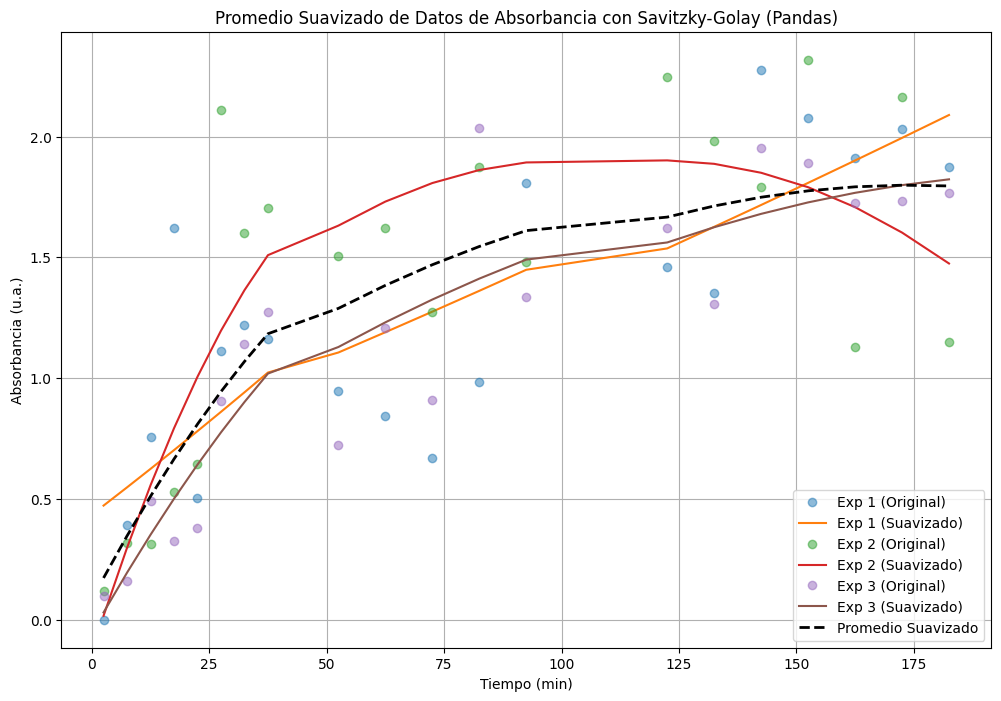

In [2]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Reformatear los datos para suavizado
data_melted = data.melt(id_vars=["Time (min)"], var_name="Experiment", value_name="Absorbance")
data_melted["Experiment"] = data_melted["Experiment"].str.extract(r'(\d)').astype(int)

# Configuración para el suavizado
n_corridas = 3
n_puntos_por_corrida = len(data_melted) // n_corridas
window_length = 20  # Longitud de la ventana (debe ser impar)
polyorder = 2  # Orden del polinomio

# Reestructurar los datos en corridas
data_melted["Group"] = data_melted.groupby("Experiment").cumcount() // n_puntos_por_corrida

# Aplicar el filtro Savitzky-Golay para cada corrida
data_melted["Smoothed"] = data_melted.groupby(["Experiment", "Group"])["Absorbance"].transform(
    lambda x: savgol_filter(x, window_length, polyorder) if len(x) >= window_length else x
)

# Calcular el promedio suavizado
promedio_suavizado = data_melted.groupby("Time (min)")["Smoothed"].mean().reset_index()
promedio_suavizado.rename(columns={"Smoothed": "Average Smoothed"}, inplace=True)

# Graficar datos originales y suavizados
plt.figure(figsize=(12, 8))

# Graficar cada experimento original y suavizado
for exp in data_melted["Experiment"].unique():
    exp_data = data_melted[data_melted["Experiment"] == exp]
    plt.plot(exp_data["Time (min)"], exp_data["Absorbance"], 'o', alpha=0.5, label=f'Exp {exp} (Original)')
    plt.plot(exp_data["Time (min)"], exp_data["Smoothed"], '-', label=f'Exp {exp} (Suavizado)')

# Graficar promedio suavizado
plt.plot(promedio_suavizado["Time (min)"], promedio_suavizado["Average Smoothed"], 'k--', linewidth=2, label='Promedio Suavizado')

# Configuración de la gráfica
plt.title('Promedio Suavizado de Datos de Absorbancia con Savitzky-Golay (Pandas)')
plt.xlabel('Tiempo (min)')
plt.ylabel('Absorbancia (u.a.)')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import os

# Ruta del directorio de salida
output_dir = "../files/output"

# Verificar si el directorio de salida existe, si no, crearlo
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Guardar únicamente tiempo y promedio suavizado en el DataFrame final
promedio_suavizado.to_csv(os.path.join(output_dir, "data_clean.csv"), index=False)


In [4]:
from scipy.optimize import curve_fit
import pickle
import os
import pandas as pd

# Crear el directorio de modelos si no existe
models_dir = "../files/models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Directorio creado: {models_dir}")

# Cargar los datos experimentales
df = pd.read_csv("../files/output/data_clean.csv")
t = df["Time (min)"].values
A = df["Average Smoothed"].values


l = 0.64 # Longitud de la celda en cm
# diam = 16 # Diámetro de la nano particula en nm
# epsilon = 0.202*np.exp(0.251*diam) # http://dx.doi.org/10.1016/j.scitotenv.2017.04.055
epsilon = 1445+35 # Absortividad molar
n_train = 8  # Número de puntos para el ajuste
el = l*epsilon  # Absortividad molar por cm
epsilon

Directorio creado: ../files/models


1480

In [5]:
# Definir el modelo
def model_1(t, Ag, k, p_td):
    return el * (p_td * np.exp(-k * t) + Ag * (1 - np.exp(-k * t)))

# Ajustar el modelo
t_fit = t[:n_train]
A_fit = A[:n_train]

initial_guess = [0.0018, 1, 0.00018]
bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])

params, covariance = curve_fit(model_1, t_fit, A_fit, p0=initial_guess, bounds=bounds)

# Guardar los parámetros y el modelo en el Pickle
model_data = {
    "parameters": params,
    "covariance": covariance,
    "model": model_1  # Incluir la función del modelo
}

model_path = os.path.join(models_dir, "model_1.pkl")
with open(model_path, "wb") as file:
    pickle.dump(model_data, file)

print(f"Modelo guardado en: {model_path}")
print("Parámetros ajustados:", params)

Modelo guardado en: ../files/models\model_1.pkl
Parámetros ajustados: [3.00567126e-03 1.35988032e-02 8.37665934e-05]


In [6]:
# Definir el modelo
def model_2(t, p_td, theta, k):
    return el * (p_td + theta * (1 - np.exp(-k * t)))

# Ajustar el modelo
t_fit = t[:n_train]
A_fit = A[:n_train]

initial_guess = [0.0018, 1, 0.00018]
bounds = ([0, 0, 0], [np.inf, np.inf, np.inf])

params, covariance = curve_fit(model_2, t_fit, A_fit, p0=initial_guess, bounds=bounds)

# Guardar los parámetros y el modelo en el Pickle
model_data = {
    "parameters": params,
    "covariance": covariance,
    "model": model_2  # Incluir la función del modelo
}

model_path = os.path.join(models_dir, "model_2.pkl")
with open(model_path, "wb") as file:
    pickle.dump(model_data, file)

print(f"Modelo guardado en: {model_path}")
print("Parámetros ajustados:", params)


Modelo guardado en: ../files/models\model_2.pkl
Parámetros ajustados: [8.37665933e-05 2.92190466e-03 1.35988032e-02]


In [7]:
# Definir el modelo
def model_3(t, x1, y1, k, beta):
    return el * (x1 + y1 * np.log(np.abs(1 + beta) / (np.exp(-k * t) + beta)))

# Ajustar el modelo
t_fit = t[:n_train]
A_fit = A[:n_train]

initial_guess = [8.49423874e-05, 6.41272011e-03, 1.84094771e-02, 2]
bounds = ([0, 0, 0, 0], [8.6e-05, 6.5e-03, 1.9e-02, 3])

params, covariance = curve_fit(model_3, t_fit, A_fit, p0=initial_guess, bounds=bounds)

# Guardar los parámetros y el modelo en el Pickle
model_data = {
    "parameters": params,
    "covariance": covariance,
    "model": model_3  # Incluir la función del modelo
}

model_path = os.path.join(models_dir, "model_3.pkl")
with open(model_path, "wb") as file:
    pickle.dump(model_data, file)

print(f"Modelo guardado en: {model_path}")
print("Parámetros ajustados:", params)




Modelo guardado en: ../files/models\model_3.pkl
Parámetros ajustados: [8.51711588e-05 5.69137321e-03 1.90000000e-02 1.75218576e+00]


In [8]:
# import numpy as np
# import os
# import pickle
# from scipy.optimize import curve_fit

# # Supongamos que 'el', 't', 'A', y 'models_dir' ya están definidos.
# # También 'n_train', que indica hasta dónde usas tus datos para ajustar.

# ##############################################################################
# # 1. Definir tu modelo original con los 4 parámetros: (x1, y1, k, beta)
# ##############################################################################
# def model_3(t, x1, y1, k, beta):
#     return el * (x1 + y1 * np.log(np.abs(1 + beta) / (np.exp(-k * t) + beta)))

# ##############################################################################
# # 2. Función auxiliar (wrapper) que fija 'beta' y solo ajusta x1, y1, k.
# ##############################################################################
# def model_3_fixed_beta(t, x1, y1, k, beta_fixed):
#     return model_3(t, x1, y1, k, beta_fixed)

# ##############################################################################
# # 3. Función para calcular el R^2
# ##############################################################################
# def r_squared(y_true, y_pred):
#     ss_res = np.sum((y_true - y_pred) ** 2)
#     ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
#     return 1 - (ss_res / ss_tot)

# ##############################################################################
# # 4. Separa los datos de entrenamiento (opcional)
# ##############################################################################
# t_fit = t[:n_train]
# A_fit = A[:n_train]

# ##############################################################################
# # 5. Definir el rango de búsqueda para beta
# ##############################################################################
# beta_values = np.linspace(2, 3, 10000)  # por ejemplo, 10000 valores entre 2 y 3

# ##############################################################################
# # 6. Definir los bounds y las iniciales para (x1, y1, k)
# ##############################################################################
# initial_guess_3params = [8.49423874e-05, 6.41272011e-03, 1.84094771e-02]  # x1, y1, k
# bounds_3params = ([0, 0, 0], [8.49423874e-05, 6.41272011e-03, 1.84094771e-02])                # x1, y1, k

# ##############################################################################
# # 7. Bucle de búsqueda sobre 'beta' buscando el R^2 máximo
# ##############################################################################
# best_beta = None
# best_params_3 = None  # (x1, y1, k)
# best_r2 = -np.inf     # R^2 inicial muy bajo

# for beta_candidate in beta_values:
    
#     # Definimos la función de ajuste que solo recibe (t, x1, y1, k)
#     # y usa beta_candidate como fijo.
#     def func_for_curve_fit(t, x1, y1, k):
#         return model_3_fixed_beta(t, x1, y1, k, beta_candidate)
    
#     try:
#         # Ajuste con curve_fit fijando beta_candidate
#         popt, pcov = curve_fit(
#             func_for_curve_fit,
#             t_fit,
#             A_fit,
#             p0=initial_guess_3params,
#             bounds=bounds_3params
#         )
        
#         # Calculamos la predicción y el R^2
#         A_pred = func_for_curve_fit(t_fit, *popt)
#         current_r2 = r_squared(A_fit, A_pred)
        
#         # Verificamos si supera el mejor R^2 encontrado hasta ahora
#         if current_r2 > best_r2:
#             best_r2 = current_r2
#             best_beta = beta_candidate
#             best_params_3 = popt  # (x1, y1, k)

#     except RuntimeError as e:
#         # A veces curve_fit no converge, puedes ignorar o loguear
#         print(f"Fallo de convergencia con beta={beta_candidate}: {e}")
#         continue

# ##############################################################################
# # 8. Revisar y mostrar el mejor resultado
# ##############################################################################
# if best_beta is not None:
#     print(f"Mejor beta encontrado en el rango: {best_beta}")
#     print(f"Parámetros (x1, y1, k) = {best_params_3}")
#     print(f"Mejor R^2 logrado = {best_r2}")
# else:
#     print(f"No se encontró ninguna solución válida en todo el rango de beta.")

# ##############################################################################
# # 9. (Opcional) Guardar el modelo con los parámetros encontrados
# ##############################################################################
# if best_beta is not None:
#     # Armamos 'params' de 4 elementos, con la beta que maximizó R^2
#     params_4 = [best_params_3[0], best_params_3[1], best_params_3[2], best_beta]
    
#     # La covarianza asociada a 4 parámetros es diferente a la de 3,
#     # pero a modo ilustrativo la dejamos en None o podrías guardarte la
#     # de 3 parámetros (pcov) y documentar esta diferencia.
#     covariance_4 = None

#     model_data = {
#         "parameters": params_4,
#         "covariance": covariance_4,
#         "model": model_3
#     }

#     model_path = os.path.join(models_dir, "model_3_bestR2.pkl")
#     with open(model_path, "wb") as f:
#         pickle.dump(model_data, f)

#     print(f"Modelo guardado en: {model_path}")


In [9]:
from scipy.special import lambertw

# Definir el modelo 4
def model_4(t, c1, k, x1, y1):
    return el * (x1 - y1 * np.real(lambertw(c1 * np.exp(-k * t))))

# Ajustar el modelo
t_fit = t[:n_train]
A_fit = A[:n_train]

initial_guess = [0.15, 0.027, 0.001356, 0.0016]
bounds = ([0, 0, 0, 0], [0.985, 10, 1, 0.0032])  # Margen ajustado

params, covariance = curve_fit(model_4, t_fit, A_fit, p0=initial_guess, bounds=bounds)

# Guardar los parámetros y el modelo en el Pickle
model_data = {
    "parameters": params,
    "covariance": covariance,
    "model": model_4  # Incluir la función del modelo
}

model_path = os.path.join(models_dir, "model_4.pkl")
with open(model_path, "wb") as file:
    pickle.dump(model_data, file)

print(f"Modelo guardado en: {model_path}")
print("Parámetros ajustados:", params)



Modelo guardado en: ../files/models\model_4.pkl
Parámetros ajustados: [0.985      0.03746492 0.00186091 0.0032    ]


In [10]:
# import numpy as np
# import os
# import pickle
# from scipy.optimize import curve_fit
# from scipy.special import lambertw

# ##############################################################################
# # 1. Definimos el modelo original con 4 parámetros: (c1, k, x1, y1)
# ##############################################################################
# def model_4(t, c1, k, x1, y1):
#     return el * (x1 - y1 * np.real(lambertw(c1 * np.exp(-k * t))))

# ##############################################################################
# # 2. Definir una función auxiliar (wrapper) para fijar y1
# ##############################################################################
# def model_4_fixed_y1(t, c1, k, x1, y1_fixed):
#     # Reutiliza la misma model_4, pero con y1 = y1_fixed
#     return model_4(t, c1, k, x1, y1_fixed)

# ##############################################################################
# # 3. Función para calcular R^2
# ##############################################################################
# def r_squared(y_true, y_pred):
#     ss_res = np.sum((y_true - y_pred)**2)
#     ss_tot = np.sum((y_true - np.mean(y_true))**2)
#     return 1 - ss_res / ss_tot

# ##############################################################################
# # 4. Datos de entrenamiento
# ##############################################################################
# # Supongamos que 't' y 'A' estén definidos, y 'el' también.
# # Ajusta n_train según tus necesidades:
# t_fit = t[:n_train]
# A_fit = A[:n_train]

# ##############################################################################
# # 5. Definir el rango de búsqueda de y1 y la meta de R^2
# ##############################################################################
# y1_values = np.linspace(0, 2, 5000)  # 50 pasos entre 1.0 y 2.0
# target_r2 = 0.9965

# ##############################################################################
# # 6. Definir los bounds y la semilla inicial para (c1, k, x1) - sin y1
# ##############################################################################
# initial_guess_3params = [0.15, 0.027, 0.001356]  # (c1, k, x1)
# bounds_3params = ([0, 0, 0], [0.985, 1, 1])          # Ajustar según tu caso

# ##############################################################################
# # 7. Bucle de búsqueda sobre y1
# ##############################################################################
# best_y1 = None
# best_params_3 = None
# best_r2 = -np.inf

# for y1_candidate in y1_values:
    
#     def func_for_curve_fit(t, c1, k, x1):
#         return model_4_fixed_y1(t, c1, k, x1, y1_candidate)
    
#     try:
#         # Ajustar c1, k, x1 con y1 fijado
#         popt, pcov = curve_fit(
#             func_for_curve_fit,
#             t_fit,
#             A_fit,
#             p0=initial_guess_3params,
#             bounds=bounds_3params
#         )
        
#         # Predecir y calcular R^2
#         A_pred = func_for_curve_fit(t_fit, *popt)
#         current_r2 = r_squared(A_fit, A_pred)
        
#         # Verificamos si alcanzamos el R^2 deseado
#         if current_r2 >= target_r2:
#             best_y1 = y1_candidate
#             best_params_3 = popt  # (c1, k, x1)
#             best_r2 = current_r2
#             break  # detenemos la búsqueda al encontrar el primer y1 con R^2 suficiente
#     except RuntimeError as e:
#         # curve_fit puede fallar en la convergencia
#         print(f"Fallo de convergencia con y1={y1_candidate}: {e}")
#         continue

# ##############################################################################
# # 8. Verificar resultados
# ##############################################################################
# if best_y1 is not None:
#     print(f"Encontrado y1 mínimo con R^2 >= {target_r2}: {best_y1:.4f}")
#     print(f"Parámetros (c1, k, x1) = {best_params_3}")
#     print(f"R^2 logrado = {best_r2:.5f}")
    
#     # (Opcional) Si deseas combinar y1 con popt para guardar en un pickle:
#     params_4 = [best_params_3[0], best_params_3[1], best_params_3[2], best_y1]
    
#     # No tenemos una covarianza completa en 4D, ya que aquí solo se optimizaron 3 params.
#     # Si deseas la covarianza real de 4 parámetros, deberías hacer un "ajuste final"
#     # con y1 arrancando en best_y1.
#     covariance_4 = None

#     model_data = {
#         "parameters": params_4,
#         "covariance": covariance_4,
#         "model": model_4
#     }
    
#     # Guardar en pickle
#     model_path = os.path.join(models_dir, "model_4_minY1.pkl")
#     with open(model_path, "wb") as file:
#         pickle.dump(model_data, file)
    
#     print(f"Modelo guardado en: {model_path}")

# else:
#     print(f"No se encontró un valor de y1 en [{y1_values[0]}, {y1_values[-1]}] "
#           f"que logre R^2 >= {target_r2}.")


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from sklearn.metrics import r2_score

def graf_and_save(model_pickle_path, data_path, output_dir, n_train):
    """
    Genera una gráfica personalizada entre datos experimentales, modelo ajustado y predicciones,
    y muestra el valor de R^2 directamente en la gráfica.
    
    Parameters:
        model_pickle_path (str): Ruta al archivo Pickle con el modelo ajustado.
        data_path (str): Ruta al archivo CSV con los datos experimentales.
        output_dir (str): Directorio donde se guardará la gráfica.
        n_train (int): Número de puntos utilizados para entrenar el modelo.
    """
    # Crear el directorio de salida si no existe
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Directorio creado: {output_dir}")

    # Identificar el nombre del modelo a partir del archivo Pickle
    model_name = os.path.splitext(os.path.basename(model_pickle_path))[0].replace("_", " ").capitalize()

    # Cargar el modelo desde el archivo Pickle
    with open(model_pickle_path, "rb") as file:
        model_data = pickle.load(file)
    params = model_data["parameters"]
    model = model_data["model"]

    # Cargar los datos experimentales
    df = pd.read_csv(data_path)
    t = df["Time (min)"].values
    A = df["Average Smoothed"].values

    # Separar datos de entrenamiento y predicción
    t_train = t[:n_train]
    A_train = A[:n_train]
    t_predict = t[n_train:]
    A_predict = A[n_train:]

    # Predicciones del modelo
    A_model = model(t, *params)

    # Calcular R^2
    r2 = r2_score(A, A_model)

    # Crear la gráfica
    plt.figure(figsize=(12, 8))

    # Colores personalizados
    colors = {
        "Modelo ajustado": "#0077b6",  # Azul oscuro
        "Datos entrenamiento": "#ff006e",  # Fucsia
        "Datos predicción": "#ffca3a"  # Amarillo pastel
    }

    # Graficar modelo ajustado en todo el rango
    plt.plot(
        t, A_model,
        color=colors["Modelo ajustado"],
        label="Modelo ajustado",
        linewidth=3,
        zorder=2,
    )

    # Graficar datos de entrenamiento
    plt.scatter(
        t_train, A_train,
        color=colors["Datos entrenamiento"],
        label="Datos de entrenamiento",
        s=80,
        alpha=0.9,
        zorder=3,
    )

    # Graficar datos de predicción
    plt.scatter(
        t_predict, A_predict,
        color=colors["Datos predicción"],
        label="Datos de predicción",
        s=80,
        alpha=0.9,
        zorder=3,
    )

    # Mostrar R^2 directamente en la gráfica
    plt.text(
        0.05, 0.95, f"$R^2 = {r2:.4f}$",
        fontsize=16,
        color="black",
        transform=plt.gca().transAxes,
        ha="left", va="top",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white")
    )

    # Personalización de la gráfica
    plt.title(f"{model_name}", fontsize=20, fontweight="bold", color="#023047")
    plt.suptitle("Visualización de Entrenamiento y Predicción", fontsize=14, color="gray")
    plt.xlabel("Tiempo (min)", fontsize=14, color="#6c757d")
    plt.ylabel("Absorbancia (u.a.)", fontsize=14, color="#6c757d")
    plt.xticks(fontsize=12, color="#6c757d")
    plt.yticks(fontsize=12, color="#6c757d")
    plt.grid(axis="y", linestyle="--", alpha=0.6, color="#b0b0b0")

    # Mostrar leyenda por defecto
    plt.legend(fontsize=12, loc="best", frameon=True, facecolor="white", edgecolor="gray")

    plt.tight_layout()

    # Guardar la gráfica
    output_file = os.path.join(output_dir, f"{model_name.replace(' ', '_')}_comparison.png")
    plt.savefig(output_file)
    plt.close()
    print(f"Gráfica guardada en: {output_file}")




In [12]:
import os
# Directorios
models_dir = "../files/models"
data_path = "../files/output/data_clean.csv"
output_dir = "../files/plots"

# Iterar sobre los archivos en la carpeta models
for model_file in os.listdir(models_dir):
    if model_file.endswith(".pkl"):  # Procesar solo archivos .pkl
        model_path = os.path.join(models_dir, model_file)
        graf_and_save(
            model_pickle_path=model_path,
            data_path=data_path,
            output_dir=output_dir,
            n_train=n_train
        )

Directorio creado: ../files/plots
Gráfica guardada en: ../files/plots\Model_1_comparison.png
Gráfica guardada en: ../files/plots\Model_2_comparison.png
Gráfica guardada en: ../files/plots\Model_3_comparison.png
Gráfica guardada en: ../files/plots\Model_4_comparison.png
